<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    make_scorer
)
from scipy.stats import randint as sp_randInt

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()

In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Загрузили данные и выполнили их ресемплирование по одному часу.

## Анализ

Оценим суточное скользащее среднее и стандартное отклонение.

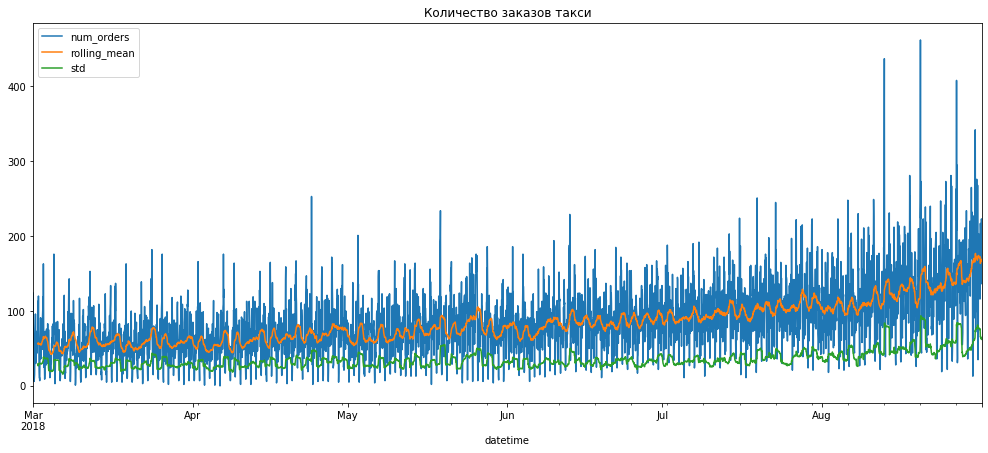

In [6]:
df['rolling_mean'] = df.rolling(24).mean()
df['std'] = df['num_orders'].rolling(24).std()
df.plot(figsize=(17, 7), title='Количество заказов такси');

Видно, что к концу августа количество заказов в среднем растет. Определим тренд и сезонность данных.

In [7]:
decomposed = seasonal_decompose(df['num_orders'])

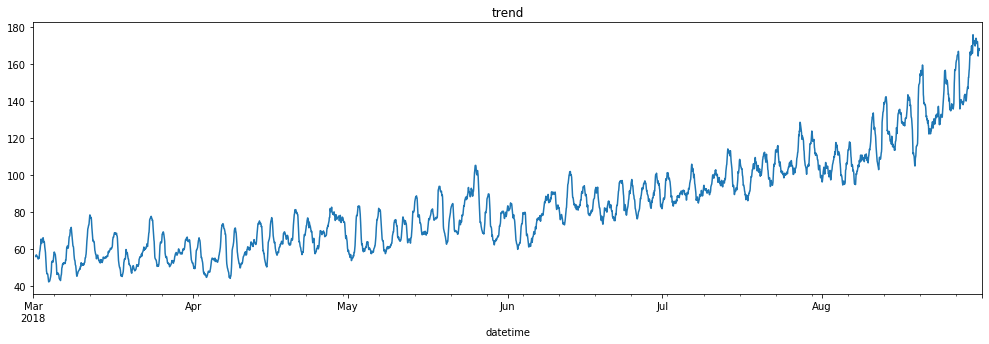

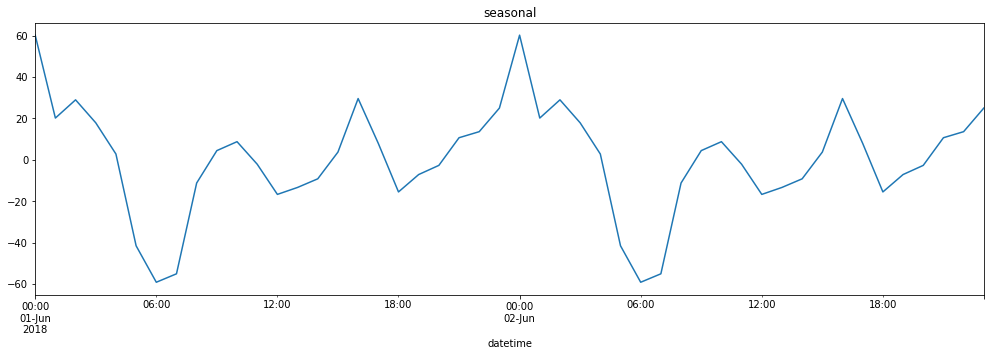

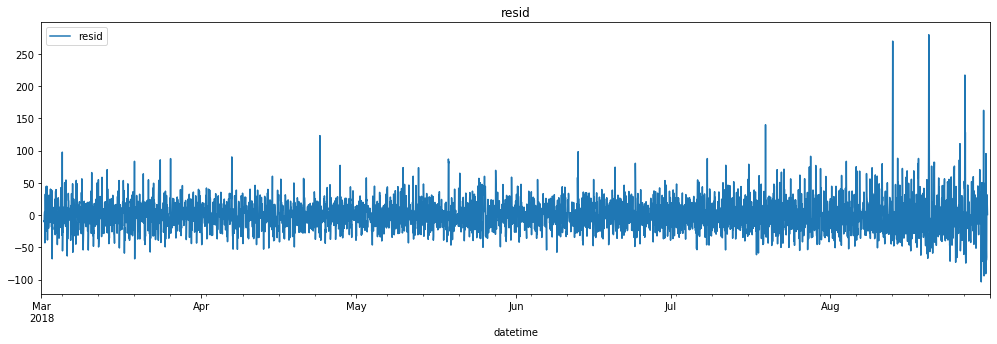

In [8]:
plt.figure(figsize=(17, 5))
decomposed.trend['2018-03-01':'2018-08-31'].plot(ax=plt.gca(), title='trend')
plt.show()
plt.figure(figsize=(17, 5))
decomposed.seasonal['2018-06-01':'2018-06-02'].plot(ax=plt.gca(), title='seasonal')
plt.show()
plt.figure(figsize=(17, 5))
decomposed.resid['2018-03-01':'2018-08-31'].plot(ax=plt.gca(), title='resid')
plt.legend();

Дейстивительно есть тренд на увеличение количества заказов к концу августа. Для определения сезонности малый период наблюдения.

Количество заказов увеличивается с ускорением, В августе много остатков, что повлияет на качество модели на тесте. Судя по суточной сезонности пик заказов приходится на полночь. Рассмотрим укрупненную сезонность.

In [9]:
df_daily = df.resample('1D').sum()

Больше всего такси заказывают в понедельник и пятницу.


## Обучение

In [10]:
df = df.drop(["rolling_mean","std"], axis=1)

Добавим колендарные признаки, отстающие значения, и суточное сколльзящее среднее.

In [11]:
def make_features(df, max_lag, rolling_mean_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift(1).rolling(rolling_mean_size).mean()

make_features(df, 50, 50)

In [12]:
df.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разделим выборку на обучающаю и тестовую (10%), предварительно удалив строчки с пустыми значеними

In [13]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

f_train = train.drop('num_orders', axis=1)
f_test = test.drop('num_orders', axis=1)
t_train = train['num_orders']
t_test = test['num_orders']

In [14]:
def rmse(predict, target):
    return round(mean_squared_error(target, predict)**0.5,2)

Определим гипермараметры моделей CatBoostRegressor и RandomForestRegressor

In [15]:
model_LR = LinearRegression()
tscv = TimeSeriesSplit(n_splits=10)
score = cross_val_score(model_LR, f_train, t_train, cv=tscv, scoring='neg_mean_squared_error')
print("RMSE обучающей выборки:", abs(score.mean())**0.5)

RMSE обучающей выборки: 24.39890206451145


In [16]:
model_cat = CatBoostRegressor(random_state=12345, eval_metric='RMSE')
parameters = {'iterations' : sp_randInt(10, 51),
              'depth' : sp_randInt(2, 7),
             }
tscv = TimeSeriesSplit(n_splits=10)
randm_src_cat = model_cat.randomized_search(param_distributions=parameters, cv=tscv, X=f_train, shuffle=False,
                                        y=t_train, verbose=False, search_by_train_test_split=False)

Training on fold [0/10]
0:	learn: 61.6130729	test: 64.1449488	best: 64.1449488 (0)	total: 141ms	remaining: 4.66s
1:	learn: 60.2078744	test: 62.7754476	best: 62.7754476 (1)	total: 144ms	remaining: 2.3s
2:	learn: 58.9362889	test: 61.4939859	best: 61.4939859 (2)	total: 146ms	remaining: 1.5s
3:	learn: 57.6615798	test: 60.2516447	best: 60.2516447 (3)	total: 148ms	remaining: 1.11s
4:	learn: 56.4553932	test: 59.0537923	best: 59.0537923 (4)	total: 151ms	remaining: 879ms
5:	learn: 55.2232366	test: 57.8139969	best: 57.8139969 (5)	total: 154ms	remaining: 718ms
6:	learn: 54.0786091	test: 56.6285578	best: 56.6285578 (6)	total: 156ms	remaining: 603ms
7:	learn: 52.9223562	test: 55.4942691	best: 55.4942691 (7)	total: 159ms	remaining: 516ms
8:	learn: 51.7818117	test: 54.3723962	best: 54.3723962 (8)	total: 161ms	remaining: 447ms
9:	learn: 50.6418342	test: 53.2557110	best: 53.2557110 (9)	total: 165ms	remaining: 396ms
10:	learn: 49.6177268	test: 52.2540828	best: 52.2540828 (10)	total: 168ms	remaining: 350

1:	learn: 64.5613898	test: 72.5155506	best: 72.5155506 (1)	total: 5.82ms	remaining: 93.1ms
2:	learn: 63.0799886	test: 71.0527488	best: 71.0527488 (2)	total: 8.86ms	remaining: 91.6ms
3:	learn: 61.5030142	test: 69.3972174	best: 69.3972174 (3)	total: 12ms	remaining: 89.8ms
4:	learn: 60.0900044	test: 67.9301075	best: 67.9301075 (4)	total: 14.6ms	remaining: 84.9ms
5:	learn: 58.6434037	test: 66.5012207	best: 66.5012207 (5)	total: 17.3ms	remaining: 80.7ms
6:	learn: 57.2441458	test: 65.0665673	best: 65.0665673 (6)	total: 19.8ms	remaining: 76.3ms
7:	learn: 55.9101144	test: 63.6519815	best: 63.6519815 (7)	total: 23.9ms	remaining: 77.6ms
8:	learn: 54.6697942	test: 62.3887898	best: 62.3887898 (8)	total: 27.8ms	remaining: 77.2ms
9:	learn: 53.4388937	test: 61.1906123	best: 61.1906123 (9)	total: 30.6ms	remaining: 73.4ms
10:	learn: 52.3014636	test: 59.9834534	best: 59.9834534 (10)	total: 33.3ms	remaining: 69.6ms
11:	learn: 51.0825886	test: 58.8215908	best: 58.8215908 (11)	total: 36.3ms	remaining: 66.5

28:	learn: 38.1510284	test: 46.6542227	best: 46.6542227 (28)	total: 87.9ms	remaining: 15.2ms
29:	learn: 37.4419890	test: 45.8282007	best: 45.8282007 (29)	total: 91.7ms	remaining: 12.2ms
30:	learn: 36.7836850	test: 45.0116959	best: 45.0116959 (30)	total: 95.2ms	remaining: 9.21ms
31:	learn: 36.1385837	test: 44.2166146	best: 44.2166146 (31)	total: 98.7ms	remaining: 6.17ms
32:	learn: 35.4955499	test: 43.4072334	best: 43.4072334 (32)	total: 102ms	remaining: 3.1ms
33:	learn: 34.9001643	test: 42.6668200	best: 42.6668200 (33)	total: 106ms	remaining: 0us

bestTest = 42.66681996
bestIteration = 33

Training on fold [6/10]
0:	learn: 72.9232762	test: 89.9687470	best: 89.9687470 (0)	total: 3.25ms	remaining: 107ms
1:	learn: 71.0947956	test: 87.7985323	best: 87.7985323 (1)	total: 6.81ms	remaining: 109ms
2:	learn: 69.3787665	test: 85.8406617	best: 85.8406617 (2)	total: 10.6ms	remaining: 110ms
3:	learn: 67.6483794	test: 83.6739916	best: 83.6739916 (3)	total: 13.5ms	remaining: 101ms
4:	learn: 66.0404333

1:	learn: 79.3482584	test: 114.8400438	best: 114.8400438 (1)	total: 9.03ms	remaining: 145ms
2:	learn: 77.3736818	test: 112.6441926	best: 112.6441926 (2)	total: 13.9ms	remaining: 143ms
3:	learn: 75.3866025	test: 110.1443260	best: 110.1443260 (3)	total: 19.8ms	remaining: 149ms
4:	learn: 73.5384170	test: 107.9957455	best: 107.9957455 (4)	total: 24.6ms	remaining: 142ms
5:	learn: 71.6994191	test: 105.7677265	best: 105.7677265 (5)	total: 28.8ms	remaining: 134ms
6:	learn: 69.9124236	test: 103.7866969	best: 103.7866969 (6)	total: 32.8ms	remaining: 127ms
7:	learn: 68.1911011	test: 101.6945449	best: 101.6945449 (7)	total: 36.8ms	remaining: 120ms
8:	learn: 66.5015002	test: 99.7297697	best: 99.7297697 (8)	total: 43ms	remaining: 119ms
9:	learn: 64.8487854	test: 97.7316822	best: 97.7316822 (9)	total: 51.1ms	remaining: 123ms
10:	learn: 63.3582632	test: 95.9116927	best: 95.9116927 (10)	total: 55.6ms	remaining: 116ms
11:	learn: 61.8481107	test: 94.1328000	best: 94.1328000 (11)	total: 59.7ms	remaining: 

24:	learn: 37.1283251	test: 47.4171505	best: 47.4171505 (24)	total: 71.9ms	remaining: 23ms
25:	learn: 36.4540726	test: 46.8229316	best: 46.8229316 (25)	total: 74.9ms	remaining: 20.2ms
26:	learn: 35.7626591	test: 46.0840603	best: 46.0840603 (26)	total: 79.6ms	remaining: 17.7ms
27:	learn: 35.0912508	test: 45.3000949	best: 45.3000949 (27)	total: 83.1ms	remaining: 14.8ms
28:	learn: 34.4337482	test: 44.6203836	best: 44.6203836 (28)	total: 87.1ms	remaining: 12ms
29:	learn: 33.8274647	test: 43.9665525	best: 43.9665525 (29)	total: 89.7ms	remaining: 8.96ms
30:	learn: 33.2092934	test: 43.3348973	best: 43.3348973 (30)	total: 92.6ms	remaining: 5.97ms
31:	learn: 32.6438932	test: 42.7751231	best: 42.7751231 (31)	total: 96.2ms	remaining: 3.01ms
32:	learn: 32.0995967	test: 42.2079224	best: 42.2079224 (32)	total: 100ms	remaining: 0us

bestTest = 42.20792237
bestIteration = 32

Training on fold [3/10]
0:	learn: 66.1834941	test: 74.2515204	best: 74.2515204 (0)	total: 6.22ms	remaining: 199ms
1:	learn: 64.

bestTest = 43.4072334
bestIteration = 32

Training on fold [6/10]
0:	learn: 72.9232762	test: 89.9687470	best: 89.9687470 (0)	total: 4.01ms	remaining: 128ms
1:	learn: 71.0947956	test: 87.7985323	best: 87.7985323 (1)	total: 7.13ms	remaining: 111ms
2:	learn: 69.3787665	test: 85.8406617	best: 85.8406617 (2)	total: 11.2ms	remaining: 112ms
3:	learn: 67.6483794	test: 83.6739916	best: 83.6739916 (3)	total: 15.6ms	remaining: 113ms
4:	learn: 66.0404333	test: 81.8396058	best: 81.8396058 (4)	total: 19.8ms	remaining: 111ms
5:	learn: 64.4238539	test: 79.9460538	best: 79.9460538 (5)	total: 23.6ms	remaining: 106ms
6:	learn: 62.8493903	test: 78.0750901	best: 78.0750901 (6)	total: 29.3ms	remaining: 109ms
7:	learn: 61.3283608	test: 76.3392567	best: 76.3392567 (7)	total: 32.9ms	remaining: 103ms
8:	learn: 59.8554174	test: 74.7164567	best: 74.7164567 (8)	total: 36.2ms	remaining: 96.6ms
9:	learn: 58.4323802	test: 72.9760835	best: 72.9760835 (9)	total: 40.3ms	remaining: 92.7ms
10:	learn: 57.1137061	test: 71.4

2:	learn: 77.3736818	test: 112.6441926	best: 112.6441926 (2)	total: 14.8ms	remaining: 148ms
3:	learn: 75.3866025	test: 110.1443260	best: 110.1443260 (3)	total: 20.1ms	remaining: 146ms
4:	learn: 73.5384170	test: 107.9957455	best: 107.9957455 (4)	total: 24.6ms	remaining: 138ms
5:	learn: 71.6994191	test: 105.7677265	best: 105.7677265 (5)	total: 29.2ms	remaining: 131ms
6:	learn: 69.9124236	test: 103.7866969	best: 103.7866969 (6)	total: 33.6ms	remaining: 125ms
7:	learn: 68.1911011	test: 101.6945449	best: 101.6945449 (7)	total: 37.9ms	remaining: 119ms
8:	learn: 66.5015002	test: 99.7297697	best: 99.7297697 (8)	total: 41.5ms	remaining: 111ms
9:	learn: 64.8487854	test: 97.7316822	best: 97.7316822 (9)	total: 46ms	remaining: 106ms
10:	learn: 63.3582632	test: 95.9116927	best: 95.9116927 (10)	total: 51.3ms	remaining: 103ms
11:	learn: 61.8481107	test: 94.1328000	best: 94.1328000 (11)	total: 56.2ms	remaining: 98.3ms
12:	learn: 60.4005815	test: 92.3508359	best: 92.3508359 (12)	total: 60.3ms	remaining:

26:	learn: 35.7515896	test: 38.1150216	best: 38.1150216 (26)	total: 70.3ms	remaining: 39ms
27:	learn: 35.0807165	test: 37.4308837	best: 37.4308837 (27)	total: 72.9ms	remaining: 36.4ms
28:	learn: 34.4300152	test: 36.7922370	best: 36.7922370 (28)	total: 75.3ms	remaining: 33.7ms
29:	learn: 33.8216055	test: 36.1887377	best: 36.1887377 (29)	total: 78ms	remaining: 31.2ms
30:	learn: 33.1954851	test: 35.5900468	best: 35.5900468 (30)	total: 80.8ms	remaining: 28.7ms
31:	learn: 32.6274457	test: 35.0438414	best: 35.0438414 (31)	total: 84.4ms	remaining: 26.4ms
32:	learn: 32.1037665	test: 34.5261160	best: 34.5261160 (32)	total: 86.8ms	remaining: 23.7ms
33:	learn: 31.5541384	test: 33.9863683	best: 33.9863683 (33)	total: 89ms	remaining: 20.9ms
34:	learn: 30.9931725	test: 33.4511210	best: 33.4511210 (34)	total: 91.3ms	remaining: 18.3ms
35:	learn: 30.4427029	test: 32.9642216	best: 32.9642216 (35)	total: 94.3ms	remaining: 15.7ms
36:	learn: 29.9601115	test: 32.5023640	best: 32.5023640 (36)	total: 100ms	re

8:	learn: 55.8497156	test: 73.1702428	best: 73.1702428 (8)	total: 36ms	remaining: 132ms
9:	learn: 54.5831485	test: 71.8381201	best: 71.8381201 (9)	total: 39ms	remaining: 125ms
10:	learn: 53.4078596	test: 70.6076265	best: 70.6076265 (10)	total: 42.3ms	remaining: 119ms
11:	learn: 52.1762729	test: 69.2641938	best: 69.2641938 (11)	total: 46.5ms	remaining: 116ms
12:	learn: 51.0311097	test: 67.9914333	best: 67.9914333 (12)	total: 50ms	remaining: 112ms
13:	learn: 49.8705890	test: 66.7445400	best: 66.7445400 (13)	total: 53.6ms	remaining: 107ms
14:	learn: 48.7589445	test: 65.5050550	best: 65.5050550 (14)	total: 57.4ms	remaining: 103ms
15:	learn: 47.7076489	test: 64.3201646	best: 64.3201646 (15)	total: 61.8ms	remaining: 100ms
16:	learn: 46.7059847	test: 63.2056831	best: 63.2056831 (16)	total: 65.7ms	remaining: 96.6ms
17:	learn: 45.7206234	test: 62.0809897	best: 62.0809897 (17)	total: 70.5ms	remaining: 94ms
18:	learn: 44.7667996	test: 60.9844574	best: 60.9844574 (18)	total: 73.8ms	remaining: 89.4

0:	learn: 75.2160975	test: 97.5053225	best: 97.5053225 (0)	total: 8ms	remaining: 328ms
1:	learn: 73.3080168	test: 95.2157636	best: 95.2157636 (1)	total: 14.6ms	remaining: 293ms
2:	learn: 71.5156236	test: 93.1295053	best: 93.1295053 (2)	total: 19.2ms	remaining: 249ms
3:	learn: 69.7058338	test: 90.8408918	best: 90.8408918 (3)	total: 24ms	remaining: 228ms
4:	learn: 67.9973259	test: 88.8010994	best: 88.8010994 (4)	total: 31.3ms	remaining: 231ms
5:	learn: 66.3070306	test: 86.8742040	best: 86.8742040 (5)	total: 36ms	remaining: 216ms
6:	learn: 64.6696806	test: 84.9320260	best: 84.9320260 (6)	total: 43.7ms	remaining: 219ms
7:	learn: 63.0880245	test: 83.0433921	best: 83.0433921 (7)	total: 49.6ms	remaining: 211ms
8:	learn: 61.5431129	test: 81.2151494	best: 81.2151494 (8)	total: 55.8ms	remaining: 204ms
9:	learn: 60.0592719	test: 79.5390770	best: 79.5390770 (9)	total: 62.9ms	remaining: 201ms
10:	learn: 58.6447628	test: 77.7846769	best: 77.7846769 (10)	total: 66.6ms	remaining: 188ms
11:	learn: 57.2

17:	learn: 53.7278979	test: 84.0108426	best: 84.0108426 (17)	total: 79ms	remaining: 105ms
18:	learn: 52.5128498	test: 82.6601465	best: 82.6601465 (18)	total: 85.1ms	remaining: 103ms
19:	learn: 51.3757998	test: 81.0837210	best: 81.0837210 (19)	total: 90.5ms	remaining: 99.6ms
20:	learn: 50.2425237	test: 79.7095646	best: 79.7095646 (20)	total: 94.8ms	remaining: 94.8ms
21:	learn: 49.1595367	test: 78.3918818	best: 78.3918818 (21)	total: 99.7ms	remaining: 90.7ms
22:	learn: 48.1386476	test: 76.9389214	best: 76.9389214 (22)	total: 106ms	remaining: 87.2ms
23:	learn: 47.1365359	test: 75.5613425	best: 75.5613425 (23)	total: 111ms	remaining: 83.2ms
24:	learn: 46.1581408	test: 74.3713725	best: 74.3713725 (24)	total: 116ms	remaining: 78.6ms
25:	learn: 45.2214494	test: 73.0844100	best: 73.0844100 (25)	total: 120ms	remaining: 73.9ms
26:	learn: 44.2936529	test: 71.8896044	best: 71.8896044 (26)	total: 125ms	remaining: 69.2ms
27:	learn: 43.4310404	test: 70.7890436	best: 70.7890436 (27)	total: 129ms	remai

1:	learn: 66.0730032	test: 83.9877192	best: 83.9877192 (1)	total: 3.9ms	remaining: 29.2ms
2:	learn: 64.4273488	test: 82.1877656	best: 82.1877656 (2)	total: 5.48ms	remaining: 25.6ms
3:	learn: 62.8625501	test: 80.5491384	best: 80.5491384 (3)	total: 7.62ms	remaining: 24.8ms
4:	learn: 61.3685966	test: 78.9442983	best: 78.9442983 (4)	total: 9.68ms	remaining: 23.2ms
5:	learn: 59.9065784	test: 77.3971739	best: 77.3971739 (5)	total: 11.5ms	remaining: 21ms
6:	learn: 58.5271075	test: 76.0817257	best: 76.0817257 (6)	total: 13.2ms	remaining: 18.9ms
7:	learn: 57.1745283	test: 74.5207019	best: 74.5207019 (7)	total: 17.2ms	remaining: 19.3ms
8:	learn: 55.8861188	test: 73.0427163	best: 73.0427163 (8)	total: 18.9ms	remaining: 16.8ms
9:	learn: 54.6056541	test: 71.6292362	best: 71.6292362 (9)	total: 20.8ms	remaining: 14.6ms
10:	learn: 53.3391804	test: 70.2728794	best: 70.2728794 (10)	total: 23.1ms	remaining: 12.6ms
11:	learn: 52.2151818	test: 69.1526274	best: 69.1526274 (11)	total: 25.8ms	remaining: 10.8m

0:	learn: 61.6130729	test: 64.1449488	best: 64.1449488 (0)	total: 2.46ms	remaining: 98.6ms
1:	learn: 60.2078744	test: 62.7754476	best: 62.7754476 (1)	total: 4.8ms	remaining: 93.6ms
2:	learn: 58.9362889	test: 61.4939859	best: 61.4939859 (2)	total: 7.3ms	remaining: 92.5ms
3:	learn: 57.6615798	test: 60.2516447	best: 60.2516447 (3)	total: 10.9ms	remaining: 101ms
4:	learn: 56.4553932	test: 59.0537923	best: 59.0537923 (4)	total: 13.4ms	remaining: 96.5ms
5:	learn: 55.2232366	test: 57.8139969	best: 57.8139969 (5)	total: 15.7ms	remaining: 91.6ms
6:	learn: 54.0786091	test: 56.6285578	best: 56.6285578 (6)	total: 18.1ms	remaining: 88.1ms
7:	learn: 52.9223562	test: 55.4942691	best: 55.4942691 (7)	total: 21.4ms	remaining: 88.2ms
8:	learn: 51.7818117	test: 54.3723962	best: 54.3723962 (8)	total: 23.7ms	remaining: 84.3ms
9:	learn: 50.6418342	test: 53.2557110	best: 53.2557110 (9)	total: 26ms	remaining: 80.6ms
10:	learn: 49.6177268	test: 52.2540828	best: 52.2540828 (10)	total: 27.9ms	remaining: 76ms
11:	

22:	learn: 38.5834103	test: 48.9236725	best: 48.9236725 (22)	total: 69.3ms	remaining: 54.3ms
23:	learn: 37.8713984	test: 48.1243965	best: 48.1243965 (23)	total: 72.5ms	remaining: 51.4ms
24:	learn: 37.1283251	test: 47.4171505	best: 47.4171505 (24)	total: 75.7ms	remaining: 48.5ms
25:	learn: 36.4540726	test: 46.8229316	best: 46.8229316 (25)	total: 79.2ms	remaining: 45.7ms
26:	learn: 35.7626591	test: 46.0840603	best: 46.0840603 (26)	total: 82.6ms	remaining: 42.8ms
27:	learn: 35.0912508	test: 45.3000949	best: 45.3000949 (27)	total: 86ms	remaining: 40ms
28:	learn: 34.4337482	test: 44.6203836	best: 44.6203836 (28)	total: 91.1ms	remaining: 37.7ms
29:	learn: 33.8274647	test: 43.9665525	best: 43.9665525 (29)	total: 94.7ms	remaining: 34.7ms
30:	learn: 33.2092934	test: 43.3348973	best: 43.3348973 (30)	total: 98.2ms	remaining: 31.7ms
31:	learn: 32.6438932	test: 42.7751231	best: 42.7751231 (31)	total: 101ms	remaining: 28.4ms
32:	learn: 32.0995967	test: 42.2079224	best: 42.2079224 (32)	total: 104ms	r

12:	learn: 53.1969054	test: 64.0351520	best: 64.0351520 (12)	total: 41.4ms	remaining: 89.1ms
13:	learn: 51.9623807	test: 62.6561486	best: 62.6561486 (13)	total: 45ms	remaining: 86.8ms
14:	learn: 50.7882085	test: 61.3295623	best: 61.3295623 (14)	total: 49.6ms	remaining: 86ms
15:	learn: 49.6976478	test: 60.0625844	best: 60.0625844 (15)	total: 52.9ms	remaining: 82.7ms
16:	learn: 48.6306839	test: 58.7620404	best: 58.7620404 (16)	total: 56.7ms	remaining: 80.1ms
17:	learn: 47.6235930	test: 57.6336282	best: 57.6336282 (17)	total: 61.1ms	remaining: 78.1ms
18:	learn: 46.6122289	test: 56.5996797	best: 56.5996797 (18)	total: 64.9ms	remaining: 75.2ms
19:	learn: 45.6632881	test: 55.4395790	best: 55.4395790 (19)	total: 68.4ms	remaining: 71.8ms
20:	learn: 44.6848152	test: 54.2980341	best: 54.2980341 (20)	total: 71.6ms	remaining: 68.2ms
21:	learn: 43.7463614	test: 53.2082708	best: 53.2082708 (21)	total: 75.3ms	remaining: 65ms
22:	learn: 42.8437693	test: 52.1805336	best: 52.1805336 (22)	total: 80.1ms	r

1:	learn: 75.9088901	test: 106.1016534	best: 106.1016534 (1)	total: 12.8ms	remaining: 251ms
2:	learn: 74.0319597	test: 103.9121620	best: 103.9121620 (2)	total: 17.4ms	remaining: 220ms
3:	learn: 72.1381476	test: 101.5238288	best: 101.5238288 (3)	total: 21.7ms	remaining: 201ms
4:	learn: 70.3871070	test: 99.4543351	best: 99.4543351 (4)	total: 25.9ms	remaining: 187ms
5:	learn: 68.6275257	test: 97.4288607	best: 97.4288607 (5)	total: 30.6ms	remaining: 179ms
6:	learn: 66.9185998	test: 95.4211904	best: 95.4211904 (6)	total: 34.8ms	remaining: 169ms
7:	learn: 65.2561975	test: 93.4385525	best: 93.4385525 (7)	total: 39.2ms	remaining: 162ms
8:	learn: 63.6426526	test: 91.5285837	best: 91.5285837 (8)	total: 42.4ms	remaining: 151ms
9:	learn: 62.0614844	test: 89.5928183	best: 89.5928183 (9)	total: 47.8ms	remaining: 148ms
10:	learn: 60.5812320	test: 87.7203913	best: 87.7203913 (10)	total: 54.2ms	remaining: 148ms
11:	learn: 59.1377242	test: 86.1312768	best: 86.1312768 (11)	total: 58.4ms	remaining: 141ms


1:	learn: 61.7547225	test: 73.0627843	best: 73.0627843 (1)	total: 9.34ms	remaining: 84.1ms
2:	learn: 60.3110162	test: 71.6089424	best: 71.6089424 (2)	total: 13.2ms	remaining: 74.9ms
3:	learn: 58.8329954	test: 70.0829260	best: 70.0829260 (3)	total: 17.3ms	remaining: 69.3ms
4:	learn: 57.4757217	test: 68.7222543	best: 68.7222543 (4)	total: 20.8ms	remaining: 62.3ms
5:	learn: 56.1216722	test: 67.3539609	best: 67.3539609 (5)	total: 26.4ms	remaining: 61.7ms
6:	learn: 54.7959006	test: 65.9065929	best: 65.9065929 (6)	total: 30.7ms	remaining: 57.1ms
7:	learn: 53.4712169	test: 64.5501702	best: 64.5501702 (7)	total: 34.6ms	remaining: 51.9ms
8:	learn: 52.2263660	test: 63.4196937	best: 63.4196937 (8)	total: 38.9ms	remaining: 47.6ms
9:	learn: 51.0567521	test: 62.1542202	best: 62.1542202 (9)	total: 42.7ms	remaining: 42.7ms
10:	learn: 49.9264657	test: 60.9471143	best: 60.9471143 (10)	total: 46.2ms	remaining: 37.8ms
11:	learn: 48.7611516	test: 59.6979875	best: 59.6979875 (11)	total: 49.7ms	remaining: 33

19:	learn: 46.6710151	test: 58.8303342	best: 58.8303342 (19)	total: 76.2ms	remaining: 0us

bestTest = 58.83033418
bestIteration = 19

Training on fold [7/10]
0:	learn: 75.2160975	test: 97.5053225	best: 97.5053225 (0)	total: 5.7ms	remaining: 108ms
1:	learn: 73.3080168	test: 95.2157636	best: 95.2157636 (1)	total: 9.19ms	remaining: 82.8ms
2:	learn: 71.5156236	test: 93.1295053	best: 93.1295053 (2)	total: 12.9ms	remaining: 73.2ms
3:	learn: 69.7058338	test: 90.8408918	best: 90.8408918 (3)	total: 16.5ms	remaining: 65.9ms
4:	learn: 67.9973259	test: 88.8010994	best: 88.8010994 (4)	total: 20.9ms	remaining: 62.6ms
5:	learn: 66.3070306	test: 86.8742040	best: 86.8742040 (5)	total: 25ms	remaining: 58.3ms
6:	learn: 64.6696806	test: 84.9320260	best: 84.9320260 (6)	total: 29.3ms	remaining: 54.5ms
7:	learn: 63.0880245	test: 83.0433921	best: 83.0433921 (7)	total: 32.9ms	remaining: 49.3ms
8:	learn: 61.5431129	test: 81.2151494	best: 81.2151494 (8)	total: 36.7ms	remaining: 44.9ms
9:	learn: 60.0592719	test: 

31:	learn: 33.1347435	test: 36.6220286	best: 36.6220286 (31)	total: 153ms	remaining: 57.3ms
32:	learn: 32.5804731	test: 36.1125550	best: 36.1125550 (32)	total: 158ms	remaining: 52.6ms
33:	learn: 31.9876571	test: 35.5617921	best: 35.5617921 (33)	total: 164ms	remaining: 48.2ms
34:	learn: 31.4647128	test: 35.0754340	best: 35.0754340 (34)	total: 168ms	remaining: 43.2ms
35:	learn: 30.9939664	test: 34.6374554	best: 34.6374554 (35)	total: 173ms	remaining: 38.5ms
36:	learn: 30.4977223	test: 34.1681901	best: 34.1681901 (36)	total: 179ms	remaining: 33.8ms
37:	learn: 30.0471620	test: 33.7306125	best: 33.7306125 (37)	total: 184ms	remaining: 29ms
38:	learn: 29.5617278	test: 33.2204509	best: 33.2204509 (38)	total: 188ms	remaining: 24.2ms
39:	learn: 29.0873384	test: 32.7619566	best: 32.7619566 (39)	total: 195ms	remaining: 19.5ms
40:	learn: 28.6636350	test: 32.3373482	best: 32.3373482 (40)	total: 200ms	remaining: 14.6ms
41:	learn: 28.2257459	test: 31.9239892	best: 31.9239892 (41)	total: 206ms	remainin

40:	learn: 28.2661848	test: 38.3349245	best: 38.3349245 (40)	total: 181ms	remaining: 13.2ms
41:	learn: 27.8662996	test: 37.8804839	best: 37.8804839 (41)	total: 185ms	remaining: 8.8ms
42:	learn: 27.4588940	test: 37.4381907	best: 37.4381907 (42)	total: 189ms	remaining: 4.39ms
43:	learn: 27.1054446	test: 37.0495846	best: 37.0495846 (43)	total: 194ms	remaining: 0us

bestTest = 37.0495846
bestIteration = 43

Training on fold [3/10]
0:	learn: 66.1513984	test: 74.2246008	best: 74.2246008 (0)	total: 5.28ms	remaining: 227ms
1:	learn: 64.6006104	test: 72.5666599	best: 72.5666599 (1)	total: 8.87ms	remaining: 186ms
2:	learn: 63.0211938	test: 70.8793336	best: 70.8793336 (2)	total: 13.2ms	remaining: 180ms
3:	learn: 61.5647099	test: 69.4119209	best: 69.4119209 (3)	total: 17.3ms	remaining: 173ms
4:	learn: 60.0850361	test: 67.9379762	best: 67.9379762 (4)	total: 23.2ms	remaining: 181ms
5:	learn: 58.7003063	test: 66.5287370	best: 66.5287370 (5)	total: 28.1ms	remaining: 178ms
6:	learn: 57.2951425	test: 65

3:	learn: 65.9144741	test: 78.4141528	best: 78.4141528 (3)	total: 20.9ms	remaining: 209ms
4:	learn: 64.3286255	test: 76.6794708	best: 76.6794708 (4)	total: 29.6ms	remaining: 231ms
5:	learn: 62.8562494	test: 75.1010311	best: 75.1010311 (5)	total: 35.6ms	remaining: 225ms
6:	learn: 61.3404675	test: 73.3967387	best: 73.3967387 (6)	total: 40.2ms	remaining: 212ms
7:	learn: 59.8759042	test: 71.8480820	best: 71.8480820 (7)	total: 45.4ms	remaining: 204ms
8:	learn: 58.4430490	test: 70.1769941	best: 70.1769941 (8)	total: 51.5ms	remaining: 200ms
9:	learn: 57.1583690	test: 68.8609807	best: 68.8609807 (9)	total: 57.8ms	remaining: 197ms
10:	learn: 55.8679530	test: 67.3794650	best: 67.3794650 (10)	total: 64.7ms	remaining: 194ms
11:	learn: 54.5931915	test: 65.9532600	best: 65.9532600 (11)	total: 69.8ms	remaining: 186ms
12:	learn: 53.3722423	test: 64.5245200	best: 64.5245200 (12)	total: 75.1ms	remaining: 179ms
13:	learn: 52.1546796	test: 63.0647768	best: 63.0647768 (13)	total: 80.3ms	remaining: 172ms
14

4:	learn: 68.0158254	test: 89.0678701	best: 89.0678701 (4)	total: 26.5ms	remaining: 207ms
5:	learn: 66.3876219	test: 87.2023825	best: 87.2023825 (5)	total: 32.7ms	remaining: 207ms
6:	learn: 64.7587798	test: 85.3209550	best: 85.3209550 (6)	total: 38.5ms	remaining: 204ms
7:	learn: 63.2035220	test: 83.4801135	best: 83.4801135 (7)	total: 43.6ms	remaining: 196ms
8:	learn: 61.6559827	test: 81.6333996	best: 81.6333996 (8)	total: 50.3ms	remaining: 196ms
9:	learn: 60.1956102	test: 79.8782420	best: 79.8782420 (9)	total: 56.1ms	remaining: 191ms
10:	learn: 58.8024965	test: 78.2472465	best: 78.2472465 (10)	total: 62.4ms	remaining: 187ms
11:	learn: 57.4094270	test: 76.5250317	best: 76.5250317 (11)	total: 67.7ms	remaining: 180ms
12:	learn: 56.0622873	test: 74.7543268	best: 74.7543268 (12)	total: 72.7ms	remaining: 173ms
13:	learn: 54.7515323	test: 73.1010685	best: 73.1010685 (13)	total: 77.9ms	remaining: 167ms
14:	learn: 53.5699677	test: 71.7690271	best: 71.7690271 (14)	total: 83ms	remaining: 161ms
15

27:	learn: 43.4868092	test: 70.7858544	best: 70.7858544 (27)	total: 205ms	remaining: 117ms
28:	learn: 42.6581614	test: 69.6411950	best: 69.6411950 (28)	total: 213ms	remaining: 110ms
29:	learn: 41.8292312	test: 68.5094132	best: 68.5094132 (29)	total: 220ms	remaining: 103ms
30:	learn: 41.0592963	test: 67.5799128	best: 67.5799128 (30)	total: 228ms	remaining: 95.5ms
31:	learn: 40.3070558	test: 66.6238836	best: 66.6238836 (31)	total: 236ms	remaining: 88.4ms
32:	learn: 39.5908052	test: 65.6765912	best: 65.6765912 (32)	total: 243ms	remaining: 81.1ms
33:	learn: 38.8948624	test: 64.7712050	best: 64.7712050 (33)	total: 252ms	remaining: 74ms
34:	learn: 38.1815355	test: 63.7999517	best: 63.7999517 (34)	total: 261ms	remaining: 67.2ms
35:	learn: 37.5038892	test: 62.8822874	best: 62.8822874 (35)	total: 268ms	remaining: 59.6ms
36:	learn: 36.8666985	test: 62.0821752	best: 62.0821752 (36)	total: 277ms	remaining: 52.4ms
37:	learn: 36.2509696	test: 61.2900285	best: 61.2900285 (37)	total: 284ms	remaining: 

39:	learn: 29.2623957	test: 38.7290032	best: 38.7290032 (39)	total: 52.4ms	remaining: 10.5ms
40:	learn: 28.8838984	test: 38.3963887	best: 38.3963887 (40)	total: 55.6ms	remaining: 9.49ms
41:	learn: 28.4783133	test: 37.8797303	best: 37.8797303 (41)	total: 56.9ms	remaining: 8.13ms
42:	learn: 28.0901154	test: 37.4564168	best: 37.4564168 (42)	total: 58.2ms	remaining: 6.76ms
43:	learn: 27.7185920	test: 37.0356560	best: 37.0356560 (43)	total: 59.5ms	remaining: 5.41ms
44:	learn: 27.3591416	test: 36.6212142	best: 36.6212142 (44)	total: 60.8ms	remaining: 4.05ms
45:	learn: 27.0504484	test: 36.2549036	best: 36.2549036 (45)	total: 62.1ms	remaining: 2.7ms
46:	learn: 26.7384662	test: 35.9166971	best: 35.9166971 (46)	total: 63.5ms	remaining: 1.35ms
47:	learn: 26.4312012	test: 35.6086183	best: 35.6086183 (47)	total: 64.8ms	remaining: 0us

bestTest = 35.60861825
bestIteration = 47

Training on fold [3/10]
0:	learn: 66.1484546	test: 74.2149907	best: 74.2149907 (0)	total: 1.46ms	remaining: 68.4ms
1:	learn

32:	learn: 34.4333709	test: 48.4665420	best: 48.4665420 (32)	total: 46ms	remaining: 20.9ms
33:	learn: 33.8971123	test: 47.8458798	best: 47.8458798 (33)	total: 47.5ms	remaining: 19.5ms
34:	learn: 33.3372737	test: 47.1044168	best: 47.1044168 (34)	total: 49ms	remaining: 18.2ms
35:	learn: 32.8096938	test: 46.5239575	best: 46.5239575 (35)	total: 50.5ms	remaining: 16.8ms
36:	learn: 32.3156171	test: 45.9761232	best: 45.9761232 (36)	total: 52.1ms	remaining: 15.5ms
37:	learn: 31.8467967	test: 45.4825140	best: 45.4825140 (37)	total: 53.6ms	remaining: 14.1ms
38:	learn: 31.4311461	test: 44.9628298	best: 44.9628298 (38)	total: 55.1ms	remaining: 12.7ms
39:	learn: 30.9649939	test: 44.3741528	best: 44.3741528 (39)	total: 56.6ms	remaining: 11.3ms
40:	learn: 30.5399919	test: 43.9100729	best: 43.9100729 (40)	total: 58.6ms	remaining: 10ms
41:	learn: 30.1370688	test: 43.4027698	best: 43.4027698 (41)	total: 60.7ms	remaining: 8.66ms
42:	learn: 29.7673575	test: 42.9899168	best: 42.9899168 (42)	total: 62.3ms	r

2:	learn: 73.9989115	test: 103.7879366	best: 103.7879366 (2)	total: 5.19ms	remaining: 77.9ms
3:	learn: 72.1105527	test: 101.6048649	best: 101.6048649 (3)	total: 6.99ms	remaining: 76.9ms
4:	learn: 70.3381337	test: 99.6070616	best: 99.6070616 (4)	total: 8.68ms	remaining: 74.6ms
5:	learn: 68.6094623	test: 97.6401239	best: 97.6401239 (5)	total: 10.6ms	remaining: 74.1ms
6:	learn: 66.9468636	test: 95.6412655	best: 95.6412655 (6)	total: 12.3ms	remaining: 72.2ms
7:	learn: 65.3272235	test: 93.6309277	best: 93.6309277 (7)	total: 14ms	remaining: 70.2ms
8:	learn: 63.7739183	test: 91.6952651	best: 91.6952651 (8)	total: 15.9ms	remaining: 68.8ms
9:	learn: 62.2610570	test: 89.9572127	best: 89.9572127 (9)	total: 17.7ms	remaining: 67.3ms
10:	learn: 60.7767446	test: 88.2441684	best: 88.2441684 (10)	total: 19.5ms	remaining: 65.5ms
11:	learn: 59.3467237	test: 86.6435826	best: 86.6435826 (11)	total: 21.2ms	remaining: 63.7ms
12:	learn: 57.9668497	test: 85.0041211	best: 85.0041211 (12)	total: 23.3ms	remaining

31:	learn: 32.6832472	test: 35.5051882	best: 35.5051882 (31)	total: 48ms	remaining: 13.5ms
32:	learn: 32.1392107	test: 34.9524497	best: 34.9524497 (32)	total: 49.8ms	remaining: 12.1ms
33:	learn: 31.5995448	test: 34.4093911	best: 34.4093911 (33)	total: 51.4ms	remaining: 10.6ms
34:	learn: 31.1186839	test: 33.9314808	best: 33.9314808 (34)	total: 53ms	remaining: 9.09ms
35:	learn: 30.5902628	test: 33.4366592	best: 33.4366592 (35)	total: 54.7ms	remaining: 7.6ms
36:	learn: 30.0962109	test: 32.9515687	best: 32.9515687 (36)	total: 56.3ms	remaining: 6.09ms
37:	learn: 29.6692551	test: 32.5160187	best: 32.5160187 (37)	total: 57.9ms	remaining: 4.57ms
38:	learn: 29.2155170	test: 32.0868158	best: 32.0868158 (38)	total: 59.7ms	remaining: 3.06ms
39:	learn: 28.7802143	test: 31.6606526	best: 31.6606526 (39)	total: 61.7ms	remaining: 1.54ms
40:	learn: 28.3511087	test: 31.2304963	best: 31.2304963 (40)	total: 63.7ms	remaining: 0us

bestTest = 31.23049633
bestIteration = 40

Training on fold [2/10]
0:	learn: 

9:	learn: 57.0591538	test: 68.7987713	best: 68.7987713 (9)	total: 19.4ms	remaining: 60ms
10:	learn: 55.8223890	test: 67.5324062	best: 67.5324062 (10)	total: 21.6ms	remaining: 59ms
11:	learn: 54.6186580	test: 66.2564187	best: 66.2564187 (11)	total: 24.3ms	remaining: 58.6ms
12:	learn: 53.3800305	test: 64.9659188	best: 64.9659188 (12)	total: 26.5ms	remaining: 57.1ms
13:	learn: 52.1750114	test: 63.5308992	best: 63.5308992 (13)	total: 28.7ms	remaining: 55.4ms
14:	learn: 51.0181079	test: 62.2957690	best: 62.2957690 (14)	total: 30.9ms	remaining: 53.6ms
15:	learn: 49.8882307	test: 61.1443424	best: 61.1443424 (15)	total: 33.2ms	remaining: 51.9ms
16:	learn: 48.7893809	test: 59.9135138	best: 59.9135138 (16)	total: 35.5ms	remaining: 50.2ms
17:	learn: 47.7202813	test: 58.6987684	best: 58.6987684 (17)	total: 38.8ms	remaining: 49.6ms
18:	learn: 46.7341865	test: 57.5394457	best: 57.5394457 (18)	total: 40.9ms	remaining: 47.3ms
19:	learn: 45.7140755	test: 56.3377315	best: 56.3377315 (19)	total: 42.9ms	r

7:	learn: 65.3154618	test: 93.6622653	best: 93.6622653 (7)	total: 18.8ms	remaining: 77.4ms
8:	learn: 63.8142618	test: 91.8888464	best: 91.8888464 (8)	total: 21.7ms	remaining: 77ms
9:	learn: 62.3015462	test: 89.9726172	best: 89.9726172 (9)	total: 24.2ms	remaining: 74.9ms
10:	learn: 60.8610123	test: 88.1745948	best: 88.1745948 (10)	total: 26.7ms	remaining: 72.9ms
11:	learn: 59.5041945	test: 86.7235765	best: 86.7235765 (11)	total: 29.2ms	remaining: 70.5ms
12:	learn: 58.1213209	test: 85.1292211	best: 85.1292211 (12)	total: 32ms	remaining: 69ms
13:	learn: 56.7595325	test: 83.4136913	best: 83.4136913 (13)	total: 34.7ms	remaining: 66.8ms
14:	learn: 55.4758987	test: 82.0722468	best: 82.0722468 (14)	total: 37.6ms	remaining: 65.1ms
15:	learn: 54.2188055	test: 80.6938991	best: 80.6938991 (15)	total: 39.9ms	remaining: 62.3ms
16:	learn: 52.9854908	test: 79.2333066	best: 79.2333066 (16)	total: 42.3ms	remaining: 59.7ms
17:	learn: 51.7455526	test: 77.5301509	best: 77.5301509 (17)	total: 44.7ms	remaini

36:	learn: 30.4977223	test: 34.1681901	best: 34.1681901 (36)	total: 115ms	remaining: 6.22ms
37:	learn: 30.0471620	test: 33.7306125	best: 33.7306125 (37)	total: 119ms	remaining: 3.12ms
38:	learn: 29.5617278	test: 33.2204509	best: 33.2204509 (38)	total: 122ms	remaining: 0us

bestTest = 33.22045094
bestIteration = 38

Training on fold [1/10]
0:	learn: 62.6808610	test: 64.4158308	best: 64.4158308 (0)	total: 3.7ms	remaining: 141ms
1:	learn: 61.1962653	test: 62.9800242	best: 62.9800242 (1)	total: 6.6ms	remaining: 122ms
2:	learn: 59.7672652	test: 61.5933264	best: 61.5933264 (2)	total: 9.82ms	remaining: 118ms
3:	learn: 58.4261082	test: 60.2703120	best: 60.2703120 (3)	total: 13ms	remaining: 114ms
4:	learn: 57.0533984	test: 58.8985744	best: 58.8985744 (4)	total: 16.2ms	remaining: 110ms
5:	learn: 55.7267733	test: 57.5987704	best: 57.5987704 (5)	total: 19.5ms	remaining: 107ms
6:	learn: 54.5351473	test: 56.4474792	best: 56.4474792 (6)	total: 23.1ms	remaining: 106ms
7:	learn: 53.2622977	test: 55.175

35:	learn: 31.9274064	test: 39.3891461	best: 39.3891461 (35)	total: 152ms	remaining: 12.7ms
36:	learn: 31.4171189	test: 38.8681658	best: 38.8681658 (36)	total: 157ms	remaining: 8.48ms
37:	learn: 30.9157403	test: 38.4227926	best: 38.4227926 (37)	total: 161ms	remaining: 4.24ms
38:	learn: 30.4135625	test: 37.8851249	best: 37.8851249 (38)	total: 166ms	remaining: 0us

bestTest = 37.88512492
bestIteration = 38

Training on fold [4/10]
0:	learn: 67.8047724	test: 85.8878317	best: 85.8878317 (0)	total: 4.54ms	remaining: 172ms
1:	learn: 66.1837189	test: 84.0742124	best: 84.0742124 (1)	total: 8.43ms	remaining: 156ms
2:	learn: 64.5475163	test: 82.2427894	best: 82.2427894 (2)	total: 12.3ms	remaining: 147ms
3:	learn: 63.0408517	test: 80.6873189	best: 80.6873189 (3)	total: 16.3ms	remaining: 143ms
4:	learn: 61.5182332	test: 79.1475080	best: 79.1475080 (4)	total: 20.7ms	remaining: 140ms
5:	learn: 60.0926119	test: 77.7136049	best: 77.7136049 (5)	total: 25ms	remaining: 137ms
6:	learn: 58.6622076	test: 76

17:	learn: 48.7856342	test: 61.6217315	best: 61.6217315 (17)	total: 88.3ms	remaining: 103ms
18:	learn: 47.7424884	test: 60.3884594	best: 60.3884594 (18)	total: 93.9ms	remaining: 98.9ms
19:	learn: 46.7305443	test: 59.1879308	best: 59.1879308 (19)	total: 100ms	remaining: 95.1ms
20:	learn: 45.7512248	test: 58.1624119	best: 58.1624119 (20)	total: 105ms	remaining: 90.3ms
21:	learn: 44.8115545	test: 57.0317911	best: 57.0317911 (21)	total: 110ms	remaining: 85.1ms
22:	learn: 43.9034365	test: 55.8567202	best: 55.8567202 (22)	total: 116ms	remaining: 80.8ms
23:	learn: 43.0129104	test: 54.7627005	best: 54.7627005 (23)	total: 122ms	remaining: 76ms
24:	learn: 42.1841079	test: 53.7085041	best: 53.7085041 (24)	total: 126ms	remaining: 70.8ms
25:	learn: 41.3262310	test: 52.5679801	best: 52.5679801 (25)	total: 132ms	remaining: 65.8ms
26:	learn: 40.5295987	test: 51.5409527	best: 51.5409527 (26)	total: 136ms	remaining: 60.6ms
27:	learn: 39.7593219	test: 50.5945544	best: 50.5945544 (27)	total: 141ms	remaini

32:	learn: 37.9894517	test: 59.6036899	best: 59.6036899 (32)	total: 179ms	remaining: 32.6ms
33:	learn: 37.3204451	test: 58.7043442	best: 58.7043442 (33)	total: 185ms	remaining: 27.2ms
34:	learn: 36.6375540	test: 57.7324764	best: 57.7324764 (34)	total: 191ms	remaining: 21.8ms
35:	learn: 35.9935622	test: 56.8352393	best: 56.8352393 (35)	total: 197ms	remaining: 16.4ms
36:	learn: 35.3886604	test: 56.1156539	best: 56.1156539 (36)	total: 202ms	remaining: 10.9ms
37:	learn: 34.8280388	test: 55.3938515	best: 55.3938515 (37)	total: 208ms	remaining: 5.46ms
38:	learn: 34.2659548	test: 54.6743616	best: 54.6743616 (38)	total: 215ms	remaining: 0us

bestTest = 54.67436163
bestIteration = 38

Training on fold [9/10]
0:	learn: 81.4435072	test: 117.2900584	best: 117.2900584 (0)	total: 6ms	remaining: 228ms
1:	learn: 79.3330570	test: 114.8670544	best: 114.8670544 (1)	total: 11.5ms	remaining: 213ms
2:	learn: 77.2883426	test: 112.5064760	best: 112.5064760 (2)	total: 16.7ms	remaining: 201ms
3:	learn: 75.40047

In [17]:
print("Лучшая модель CatBoost:\n", randm_src_cat['params'])
best_params_cat = randm_src_cat['params']
print("Лучшая RMSE:\n", randm_src_cat['cv_results']['train-RMSE-mean'][int(randm_src_cat['params']['iterations'])-1])

Лучшая модель CatBoost:
 {'depth': 3.0, 'iterations': 48.0}
Лучшая RMSE:
 28.614136355191967


In [18]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)
model_forest = RandomForestRegressor(random_state=12345)
parameters = {'n_estimators' : sp_randInt(10, 51),
              'max_depth'    : sp_randInt(3, 6)
             }
tscv = TimeSeriesSplit(n_splits=10)
randm_src_forest = RandomizedSearchCV(estimator=model_forest, param_distributions=parameters, 
                                      cv=tscv, scoring=rmse_scorer, n_jobs=-1)
randm_src_forest.fit(f_train, t_train)
print("Лучшая модель:\n", randm_src_forest.best_estimator_)
print("Лучшая RMSE:\n", abs(randm_src_forest.best_score_))

Лучшая модель:
 RandomForestRegressor(max_depth=5, n_estimators=41, random_state=12345)
Лучшая RMSE:
 24.812


Определим качество моделей с подобранными гиперпараметрами на тестовой выборке.

## Тестирование

In [19]:
best_model_cat = CatBoostRegressor(random_state=12345, depth=int(best_params_cat['depth']), 
                                   iterations=int(best_params_cat['iterations']))
best_model_cat.fit(f_train, t_train, verbose=False);

In [20]:
best_model_forest = randm_src_forest.best_estimator_
best_model_forest.fit(f_train, t_train);

In [21]:
model_LR.fit(f_train, t_train)
pred_test_LR = model_LR.predict(f_test)

In [22]:
pred_test_cat = best_model_cat.predict(f_test)

In [23]:
pred_test_forest = best_model_forest.predict(f_test)

In [24]:
print('RMSE cat',rmse(pred_test_cat, t_test))
print('RMSE forest',rmse(pred_test_forest, t_test))
print('RMSE LinearRegression',rmse(pred_test_LR, t_test))

RMSE cat 44.06
RMSE forest 47.67
RMSE LinearRegression 43.19


Проверим модели на адекватность сравнив с моделью, предсказанием следующего значения которой будет являться предыдущее

In [25]:
pred_previous = t_test.shift(periods=1, fill_value=t_train.iloc[-1])
print('RMSE test',rmse(pred_previous, t_test))

RMSE test 58.86


Модели CatBoost и линейная регрессия показывают лучшее качество предсказаний. Модели адекватны.